# Pre-Processing Dataset

This script loads the deCarvalho et al. 2017 catalog queried from vizier. And it converts M200c to M200m and produce an output to SDSS casJobs.

In [1]:
import sys
sys.path.append('../scripts')
from file_loc import FileLocs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
import astropy.table as Table
import astropy.io.ascii as at

# Reading Initial Data

In [3]:
fl = FileLocs(dataset='sdss')

In [4]:
fl = FileLocs(dataset='sdss')
data = fl.load_catalogs('cluster/raw')

Loading Catalog: ../data/catalogs/SDSS/groupCatalog_Yang_deCarvalho2017.fits


In [5]:
data

_RAJ2000,_DEJ2000,Yang,RAJ2000,DEJ2000,<z>,logM200,R200,N200,BAX,N/R,B00,B04,SDSS,Sloan
float64,float64,int16,float64,float64,float32,float32,float32,int16,str1,str1,int16,int16,str146,str5
240.5602,16.1113,2,240.5602,16.1113,0.036,15.29,2.01,525,Y,N,0,0,"http://vizier.u-strasbg.fr/viz-bin/VizieR-4?-info=XML&-out.add=.&-source=II/294/sdss7,V/147/sdss12&-c=${+RAJ2000}+${+DEJ2000}&-c.eq=J2000.000,rm=2",Sloan
247.1149,40.8317,4,247.1149,40.8317,0.03,14.66,1.24,217,Y,Y,0,0,"http://vizier.u-strasbg.fr/viz-bin/VizieR-4?-info=XML&-out.add=.&-source=II/294/sdss7,V/147/sdss12&-c=${+RAJ2000}+${+DEJ2000}&-c.eq=J2000.000,rm=2",Sloan
247.1633,39.4674,5,247.1633,39.4674,0.03,14.81,1.4,277,Y,Y,1,0,"http://vizier.u-strasbg.fr/viz-bin/VizieR-4?-info=XML&-out.add=.&-source=II/294/sdss7,V/147/sdss12&-c=${+RAJ2000}+${+DEJ2000}&-c.eq=J2000.000,rm=2",Sloan
167.6936,28.5374,6,167.6936,28.5374,0.033,14.6,1.18,167,Y,N,0,0,"http://vizier.u-strasbg.fr/viz-bin/VizieR-4?-info=XML&-out.add=.&-source=II/294/sdss7,V/147/sdss12&-c=${+RAJ2000}+${+DEJ2000}&-c.eq=J2000.000,rm=2",Sloan
351.1194,14.6251,7,351.1194,14.6251,0.042,14.51,1.1,106,Y,N,0,0,"http://vizier.u-strasbg.fr/viz-bin/VizieR-4?-info=XML&-out.add=.&-source=II/294/sdss7,V/147/sdss12&-c=${+RAJ2000}+${+DEJ2000}&-c.eq=J2000.000,rm=2",Sloan
239.5372,27.3133,8,239.5372,27.3133,0.09,15.1,1.71,183,Y,Y,1,0,"http://vizier.u-strasbg.fr/viz-bin/VizieR-4?-info=XML&-out.add=.&-source=II/294/sdss7,V/147/sdss12&-c=${+RAJ2000}+${+DEJ2000}&-c.eq=J2000.000,rm=2",Sloan
241.5673,18.1483,9,241.5673,18.1483,0.038,14.48,1.08,143,Y,N,0,0,"http://vizier.u-strasbg.fr/viz-bin/VizieR-4?-info=XML&-out.add=.&-source=II/294/sdss7,V/147/sdss12&-c=${+RAJ2000}+${+DEJ2000}&-c.eq=J2000.000,rm=2",Sloan
223.2712,16.724,10,223.2712,16.724,0.045,14.22,0.89,106,Y,Y,1,0,"http://vizier.u-strasbg.fr/viz-bin/VizieR-4?-info=XML&-out.add=.&-source=II/294/sdss7,V/147/sdss12&-c=${+RAJ2000}+${+DEJ2000}&-c.eq=J2000.000,rm=2",Sloan
10.4693,-9.3997,11,10.4693,-9.3997,0.056,14.96,1.55,156,Y,Y,0,3,"http://vizier.u-strasbg.fr/viz-bin/VizieR-4?-info=XML&-out.add=.&-source=II/294/sdss7,V/147/sdss12&-c=${+RAJ2000}+${+DEJ2000}&-c.eq=J2000.000,rm=2",Sloan


# Convert R200c to R200m

In [41]:
from astropy.cosmology import FlatLambdaCDM
from colossus.cosmology import cosmology
from colossus.halo import concentration
from colossus.halo import mass_defs

from astropy import units as u
from astropy.constants import G, c

params = dict(H0 = 70, Om0 = 0.27, Ob0 = 0.0457, Tcmb0 = 2.7255, Neff = 3.046)
sigma8 = 0.82
ns = 0.96

astropy_cosmo = FlatLambdaCDM(**params)
astropy_cosmo.name = 'LCDM'
colossus_cosmo = cosmology.fromAstropy(astropy_cosmo, sigma8, ns, name = 'my_cosmo')

Msol = 1.98847e33
Mpc2cm = 3.086e+24
rad2deg= 180/np.pi
h=0.7
c_kms = c.value/1000

print(cosmology.getCurrent())
print('\n')

def AngularDistance(z):
    DA = float( (cosmo.luminosity_distance(z)/(1+z)**2)/u.Mpc ) # in Mpc
    return DA
AngularDistance = np.vectorize(AngularDistance)

#--- Critical universe density
def rhoc(z):
    try:
        rho_c = float(cosmo.critical_density(z)/(u.g/u.cm**3)) # in g/cm**3
    except:
        rho_c = [float(cosmo.critical_density(zi)/(u.g/u.cm**3)) for zi in z]
        rho_c = np.array(rho_c)
    
    rho_c = rho_c*(Mpc2cm**3)/Msol # in Msol/Mpc**3
    return rho_c

def convertM200toR200(M200,z, nc=200):
    ## M200 in solar masses
    ## R200 in Mpc
    rho = nc*rhoc(z)
    r200 = (3*M200/(4*np.pi/rho))**(1/3.)
    return r200/1e9

def convert_mass_defs(Mi,zi,mdef='200m'):
    ci = concentration.concentration(Mi, '200c', zi, model = 'diemer15')
    M200m, R200m, c200m = mass_defs.changeMassDefinition(Mi, ci, zi, '200c', mdef)
    return M200m, R200m, c200m


Cosmology "LCDM" 
    flat = True, Om0 = 0.2700, Ode0 = 0.7299, Ob0 = 0.0457, H0 = 70.00, sigma8 = 0.8200, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False




In [84]:
data.colnames

['_RAJ2000',
 '_DEJ2000',
 'Yang',
 'RAJ2000',
 'DEJ2000',
 '<z>',
 'logM200',
 'R200',
 'N200',
 'BAX',
 'N/R',
 'B00',
 'B04',
 'SDSS',
 'Sloan']

In [74]:
cid = np.array(data['Yang'])
ra = np.array(data['_RAJ2000'])
dec = np.array(data['_DEJ2000'])

zcls = np.array(data['<z>'])
r200c = np.array(data['R200'])/h
m200c = np.array(10**data['logM200'])/h

da     = AngularDistance(zcls)

In [75]:
out = [convert_mass_defs(Mi,zi,'200m') for Mi,zi in zip(m200c,zcls)]
m200m = np.array([line[0] for line in out])
r200m = np.array([line[1]/1000. for line in out])
c200m = np.array([line[2] for line in out])

In [76]:
thetaR200c = (r200c*h/da)*(180/np.pi)
thetaR200m = (r200m*h/da)*(180/np.pi)

In [77]:
# plt.plot([13.5,15.7],[13.5,15.7],'k--',lw=2)
# plt.scatter(np.log10(m200c),np.log10(M200m), s=100,alpha=0.2)

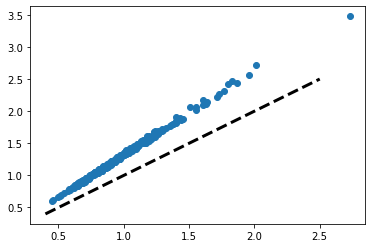

In [78]:
plt.plot([0.4,2.5],[0.4,2.5],'k--',lw=3)
plt.scatter(r200c*h,r200m*h)

# Converting to CasJobs SDSS Input

In [79]:
# Yang,RA,DEC,z,logM200,R200,thetaR200,N200

columns = ['Yang','RA','DEC','redshift','logM200','thetaR200','thetaR200m']

sdss = Table.QTable([cid,ra,dec,zcls,np.log10(m200c),thetaR200c,thetaR200m],names=columns)

sdss
sdss.write(fl.cluster_sdss,format='csv',overwrite=True)

In [80]:
sdss

Yang,RA,DEC,redshift,logM200,thetaR200,thetaR200m
int16,float64,float64,float32,float32,float64,float64
2,240.5602,16.1113,0.036,15.444902,0.7795811316295294,1.0534475724189225
4,247.1149,40.8317,0.03,14.814902,0.5730670271152717,0.7835316364742502
5,247.1633,39.4674,0.03,14.964902,0.6470111436516279,0.8791965384498562
6,167.6936,28.5374,0.033,14.754903,0.4975147606695648,0.6801442623443363
7,351.1194,14.6251,0.042,14.664903,0.36826592735879554,0.4986124388818472
8,239.5372,27.3133,0.09,15.254902,0.28232277514615234,0.3658166554840595
9,241.5673,18.1483,0.038,14.634902,0.39776457242354135,0.5383813998714762
10,223.2712,16.724,0.045,14.374902,0.27907195269288665,0.3715613166955407
11,10.4693,-9.3997,0.056,15.1149025,0.3955778673545872,0.5283403209497024


In [82]:
fl.cluster_sdss = fl.data_loc + 'groupCatalog_Yang_deCarvalho2017_toSDSS.csv'

In [ ]:
def vcirc(mass,redshift,mdef,cosmo):
    '''Calculate circular velocity in km/s for halos of mass M (Msun/h)'''
    rho_crit = astropy_cosmo.critical_density(redshift)
    if mdef[-1] == 'c':
        delta = int(mdef[:-1])
        rho = delta*rho_crit
    elif mdef[-1] == 'm':
        delta = int(mdef[:-1])
        rho = delta*rho_crit*astropy_cosmo.Om(redshift)
    else:
        raise RuntimeError("Not correct mass definition")
    v = np.sqrt(G*(np.pi*4*rho/3)**(1./3)*(mass*u.Msun)**(2./3))
    a = v.to(u.km/u.s)
    return a.value

In [11]:
gal = gal0[mask].copy()

In [12]:
def get_percentile_curve(x,y,alpha=5,Npoints=15):
    xbins  = np.percentile(x,np.linspace(0,100,Npoints))
    indices= [(x>=xl)&(x<xh) for xl, xh in zip(xbins[:-1],xbins[1:])]
    ycurve = np.array([np.percentile(y[idx],alpha) for idx in indices])
    return ycurve, 0.5*(xbins[1:]+xbins[:-1])

In [13]:
mass        = np.array(gal['mass'])
zgal        = np.array(gal['z'])
zmask       = (zgal>=0.025)&(zgal<=0.105)
ylow, zbins = get_percentile_curve(zgal[zmask],mass[zmask],Npoints=16)

## Magnitude Limit
---------------------------------------

Definit the mass limit of the study

In [14]:
mass = 10**np.array(gal['mass'])
z    = np.array(gal['z'])

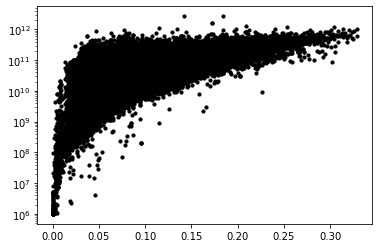

In [15]:
plt.scatter(z,mass,s=10,c='k')
plt.yscale('log')

In [16]:
zlim = (z>0.09)&(z<=0.1)
mass_lim_th = np.log10(np.percentile(mass[zlim],5))
print('Log Stellar Mass Lim: %.3f'%mass_lim_th)

Log Stellar Mass Lim: 10.056


(70000000.0, 900000000000.0)

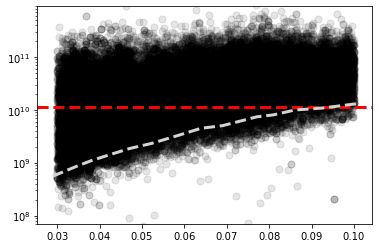

In [17]:
zmask = (z>0.03)&(z<0.1)
plt.scatter(z[zmask],mass[zmask],s=50,alpha=0.1,color='k')
plt.axhline(10**mass_lim_th,ls='--',lw=3,color='r')
plt.plot(zbins,10**ylow ,ls='--',lw=3,color='lightgray')
plt.yscale('log')
plt.ylim(7e7,9e11)

In [18]:
mass_lim = np.interp(gal0['z'],zbins,ylow)
mass_mask = gal0['mass']>=mass_lim
# mass_mask = gal0['mass']>=mass_lim_th
gal = gal0[mask&mass_mask].copy()

In [19]:
# plt.scatter(gal0['z'],10**gal0['mass'],s=10,c='lightgray',alpha=0.3)
# plt.scatter(gal['z'],10**gal['mass'],s=10,c='k')
# plt.plot(zbins,10**ylow ,ls='--',lw=3,color='r')
# plt.xlim(0.025,0.105)
# plt.yscale('log')

# Computing new variables
---------------------------------------


In [113]:
from astropy.cosmology import FlatLambdaCDM
from colossus.cosmology import cosmology

from astropy import units as u
from astropy.constants import G, c

params = dict(H0 = 70, Om0 = 0.27, Ob0 = 0.0457, Tcmb0 = 2.7255, Neff = 3.046)
sigma8 = 0.82
ns = 0.96

astropy_cosmo = FlatLambdaCDM(**params)
astropy_cosmo.name = 'LCDM'
colossus_cosmo = cosmology.fromAstropy(astropy_cosmo, sigma8, ns, name = 'my_cosmo')

#cosmology.setCosmology('planck15')

In [308]:
Msol = 1.98847e33
Mpc2cm = 3.086e+24
rad2deg= 180/np.pi
h=0.7
c_kms = c.value/1000

def AngularDistance(z):
    DA = float( (cosmo.luminosity_distance(z)/(1+z)**2)/u.Mpc ) # in Mpc
    return DA
AngularDistance = np.vectorize(AngularDistance)

#--- Critical universe density
def rhoc(z):
    try:
        rho_c = float(cosmo.critical_density(z)/(u.g/u.cm**3)) # in g/cm**3
    except:
        rho_c = [float(cosmo.critical_density(zi)/(u.g/u.cm**3)) for zi in z]
        rho_c = np.array(rho_c)
    
    rho_c = rho_c*(Mpc2cm**3)/Msol # in Msol/Mpc**3
    return rho_c

def convertM200toR200(M200,z, nc=200):
    ## M200 in solar masses
    ## R200 in Mpc
    rho = nc*rhoc(z)
    r200 = (3*M200/(4*np.pi/rho))**(1/3.)
    return r200/1e9

In [286]:
m200 = np.array(10**cat['logM200'])
r200v= np.array(cat['R200'])
zcls = np.array(cat['z'])

r200c= convertM200toR200(m200*cosmo.h,zcls)

NameError: name 'r200v' is not defined

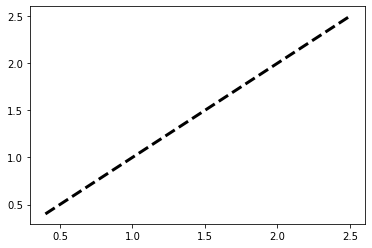

In [33]:
plt.plot([0.4,2.5],[0.4,2.5],'k--',lw=3)
plt.scatter(r200v,r200c)

## Defining R200m
See this pages for more info:<br>
https://bdiemer.bitbucket.io/colossus/halo_concentration.html#halo.concentration.concentration <br>
https://bdiemer.bitbucket.io/colossus/halo_mass_defs.html

```
from colossus.halo import profile_nfw
profile = profile_nfw.NFWProfile(M = 1E12, mdef = 'vir', z = 0.0, c = 10.0)
R200m = profile.RDelta(0.0, '200m')
rho = profile.density(R200m)
Sigma = profile.surfaceDensity(R200m)
M200m = profile.enclosedMass(R200m)
```

In [116]:
i = 150
Mi = 10**cat['logM200'][i]
Ri = float(cat['R200'][i])
zi = int(cat['z'][i])

In [125]:
from colossus.halo import concentration
from colossus.halo import mass_defs

print(cosmology.getCurrent())
print('\n')

ci = concentration.concentration(Mi, '200c', zi, model = 'diemer15')
M200m, R200m, c200m = mass_defs.changeMassDefinition(Mi, c200, zi, '200c', '200m')

print(f'Input - M200c, Rvir, c_200c: {np.log10(Mi):.2f}, {Ri:.2f}, {ci:.2f}')
print(f'Output - M200m, R200m, c_200m: {np.log10(M200m):.2f}, {R200m/1000.:.2f}, {c200m:.2f}')

Cosmology "LCDM" 
    flat = True, Om0 = 0.2700, Ode0 = 0.7299, Ob0 = 0.0457, H0 = 70.00, sigma8 = 0.8200, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


Input - M200c, Rvir, c_200c: 14.12, 0.81, 4.21
Output - M200m, R200m, c_200m: 14.30, 1.47, 6.95


In [126]:
def convert_mass_defs(Mi,zi,mdef='200m'):
    ci = concentration.concentration(Mi, '200c', zi, model = 'diemer15')
    M200m, R200m, c200m = mass_defs.changeMassDefinition(Mi, c200, zi, '200c', mdef)
    return M200m, R200m, c200m

In [293]:
out = [convert_mass_defs(Mi,zi,'200m') for Mi,zi in zip(m200,zcls)]
M200m = np.array([line[0] for line in out])
R200m = np.array([line[1]/1000. for line in out])
c200m = np.array([line[2] for line in out])

In [294]:
# plt.plot([13.5,15.7],[13.5,15.7],'k--',lw=2)
# plt.scatter(cat['logM200'],np.log10(M200m), s=100,alpha=0.2)

Text(0.5, 0, 'Rvir')

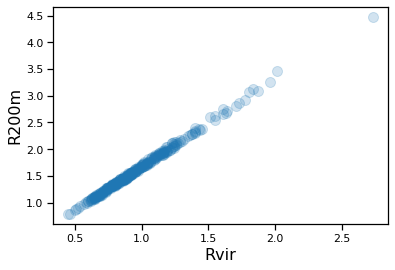

In [305]:
plt.scatter(r200v,R200m, s=100,alpha=0.2)
plt.ylabel('R200m', fontsize=16)
plt.xlabel('Rvir', fontsize=16)

## Distance From The Center
---------------------------------------

To have the phase space we need first to compute the distance from the center, $R/R_{200}$.

In [307]:
#DA = AngularDistance(zcls)
def convertDegreeToMpc(theta,z):
    da     = AngularDistance(z)
    length = (theta*np.pi/180)*da
    return length

def convertR200toM200(R200,z, nc=200):
    ## M200 in solar masses
    ## R200 in Mpc
    rho = rhoc(z)
    M200 = nc*4*np.pi*rho*R200**3/3
    return M200



In [134]:
import esutil
gcid = np.array(gal['Yang'])
cid  = np.array(cat['Yang'])

key = esutil.numpy_util.match(cid,gcid)

In [290]:
gal['row']      = np.where(mask&mass_mask)[0]
gal['redshift'] = np.zeros(len(gal))
gal['redshift'][key[1]] = cat['z'][key[0]]

gal['M200']    = np.zeros(len(gal))
gal['M200'][key[1]] = 10**cat['logM200'][key[0]]

gal['M200m']    = np.zeros(len(gal))
gal['M200m'][key[1]] = M200m[key[0]]

gal['R200']    = 99.*np.ones(len(gal))
gal['R200'][key[1]] = r200c[key[0]]

gal['R200m']    = 99.*np.ones(len(gal))
gal['R200m'][key[1]] = R200m[key[0]]

gal['R'] = convertDegreeToMpc(gal['distance']/60.,gal['redshift'])

In [291]:
gal['Rnm']= gal['R']/gal['R200m']
gal['Rn']= gal['R']/gal['R200']

Text(0.5, 0, '$R/R_{200m}$')

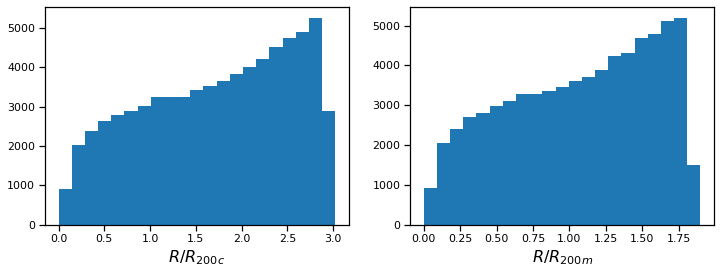

In [292]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

a = plt.hist(gal['Rn'],bins=21)
plt.xlabel(r'$R/R_{200c}$',fontsize=16)

plt.subplot(1, 2, 2)
plt.hist(gal['Rnm'],bins=21)
plt.xlabel(r'$R/R_{200m}$',fontsize=16)

The line of sight velocity
---------------------------------------


Here we compute the line of sight velocity assuming the redshift given by the Yang catalog. For the orbital classification we also need to compute the cluster circular velocity.

In [148]:
def get_los_velocity(z_gal,z_BCG):
    return c_kms*(z_gal - z_BCG)/(1 + z_BCG)

In [152]:
def vcirc(mass,redshift,mdef,cosmo):
    '''Calculate circular velocity in km/s for halos of mass M (Msun/h)'''
    rho_crit = cosmo.critical_density(redshift)
    if mdef[-1] == 'c':
        delta = int(mdef[:-1])
        rho = delta*rho_crit
    elif mdef[-1] == 'm':
        delta = int(mdef[:-1])
        rho = delta*rho_crit*cosmo.Om(redshift)
    else:
        raise RuntimeError("Not correct mass definition")
    v = np.sqrt(G*(np.pi*4*rho/3)**(1./3)*(mass*u.Msun)**(2./3))
    a = v.to(u.km/u.s)
    return a.value

In [149]:
vlos = np.array(get_los_velocity(gal['z'],gal['redshift']))
vc   = vcirc(10**gal['M200'],gal['redshift'],'200c',cosmo)

gal['vlos'] = vlos
gal['vlosn']= vlos/vc

vlosn = vlos/vc
rnorm = gal['Rn']

cut = np.abs(vlosn)<3.0

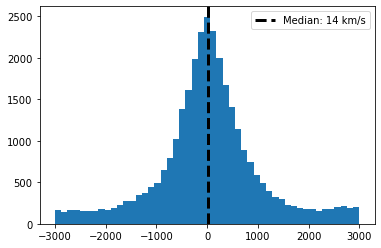

In [150]:
vmask = np.abs(vlos)<=2500.
zm = np.median(vlos[vmask])
_ = plt.hist(vlos,bins=np.linspace(-3000.,3000.))
plt.axvline(zm,ls='--',lw=3,color='k',label='Median: %i km/s'%zm)
plt.legend()

Text(0.5, 0, '$v_{los}/v_{circ}$')

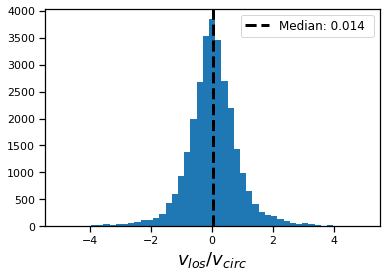

In [207]:
zm = np.median(vlos[vmask]/vc[vmask])

_ = plt.hist(vlos[vmask]/vc[vmask],bins=np.linspace(-5.,5.))
plt.axvline(zm,ls='--',lw=3,color='k',label='Median: %.3f '%zm)
plt.legend(fontsize=12)
plt.xlabel(r'$v_{los}/v_{circ}$',fontsize=18)

In [210]:
## change the r200c to the r200m. 

In [211]:
rcls = np.array(gal['R'])*u.Mpc
rcls = rcls.to(u.km).value

year   = 365*24*3600
to_gyr = year*1e9

In [213]:
tinfall = (rcls/(np.abs(vlos)+1e-9))*u.s.to(u.yr)
gal['t_infall'] = tinfall

(array([3.000e+00, 1.200e+01, 2.700e+01, 8.400e+01, 2.460e+02, 6.540e+02,
        1.442e+03, 2.922e+03, 4.575e+03, 5.393e+03, 4.949e+03, 3.617e+03,
        2.306e+03, 1.387e+03, 7.870e+02, 4.230e+02, 2.560e+02, 1.600e+02,
        5.800e+01, 4.200e+01]),
 array([ 7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,
         9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  , 11.25,
        11.5 , 11.75, 12.  ]),
 <BarContainer object of 20 artists>)

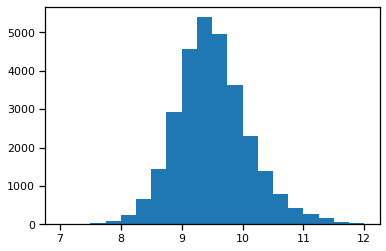

In [215]:
plt.hist(np.log10(tinfall[vmask]),bins=np.linspace(7.,12.,21))

# Orbital Classification
---------------------------------------


Here we assign the classes, orbital, infall and interloper.

In [175]:
from sklearn.ensemble import RandomForestClassifier
import joblib
loaded_rf = joblib.load("/Users/jesteves/Downloads/phase_space/classification_2d_rf.joblib")

/usr/local/anaconda/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/usr/local/anaconda/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [233]:
import pandas as pd
df   = pd.DataFrame ({ 'r2d':rnorm, 'vlos':vlosn})
tags = loaded_rf.predict(df) 


In [234]:
tag_probability = loaded_rf.predict_proba(df) 

In [235]:
tag_probability

array([[0.  , 0.69, 0.31],
       [0.03, 0.62, 0.35],
       [0.  , 0.  , 1.  ],
       ...,
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ]])

In [219]:
def get_random_assignment(prob):
    is_class = np.full(len(prob),0)
    for i,pi in enumerate(prob):
        is_class[i] = int(pi>np.random.random())
    return is_class

In [220]:
porbital= tag_probability[:,0]
pinfall = tag_probability[:,1]
pinterl = tag_probability[:,2]

orbital = get_random_assignment(porbital)
infall  = get_random_assignment(pinfall)
interl  = get_random_assignment(pinterl)

Text(0.5, 0, 'Probability')

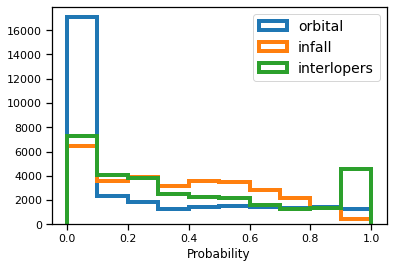

In [221]:
plt.hist(porbital[cut],histtype='step',lw=4,label='orbital')
plt.hist(pinfall[cut],histtype='step',lw=4,label='infall')
plt.hist(pinterl[cut],histtype='step',lw=4,label='interlopers')
plt.legend(fontsize=14)
plt.xlabel('Probability')

In [222]:
# np.count_nonzero(orbital)/len(orbital)
# np.count_nonzero(infall)/len(orbital)
np.count_nonzero(interl)/len(orbital)

0.7375098127172816

In [223]:
gal['infall']     = infall 
gal['orbital']    = orbital
gal['interloper'] = interl

gal['pinfall']     = pinfall 
gal['porbital']    = porbital
gal['pinterloper'] = pinterl

In [224]:
import seaborn as sns
sns.set_context('notebook')

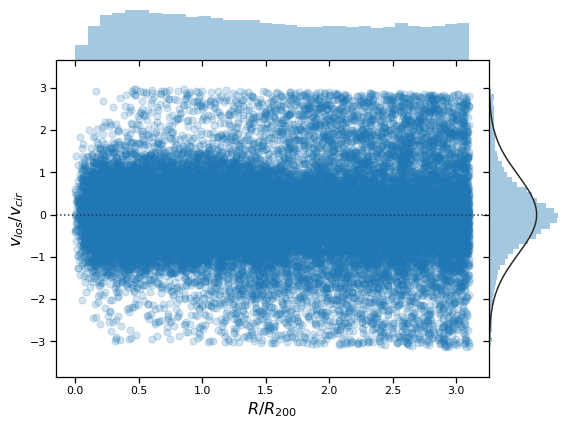

In [225]:
# ax = sns.jointplot(x=rnorm[cut], y=vlos[cut], kind="scatter", s=10, alpha=0.3, space=0)
# ax = sns.jointplot(x=rnorm[cut], y=vlos[cut], kind="resid", space=0, height=6, ratio=6, joint_kws = {'scatter_kws':dict(alpha=0.2,s=50)},ylim=(-1650,1650))
ax = sns.jointplot(x=rnorm[cut], y=vlosn[cut], kind="resid", space=0, height=6, ratio=6, joint_kws = {'scatter_kws':dict(alpha=0.2,s=50)})
ax.set_axis_labels(r'$R/R_{200}$', r'$v_{los}/v_{cir}$ ', fontsize=16)
ax.fig.set_figwidth(8)

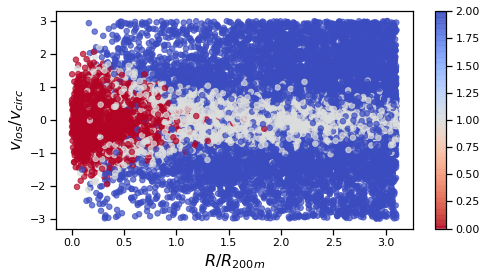

In [226]:
plt.figure(figsize=(8,4))
plt.scatter(rnorm[cut],vlosn[cut],c=tags[cut],alpha=0.7,s=30,cmap='coolwarm_r')
plt.xlabel(r'$R/R_{200m}$',fontsize=16)
plt.ylabel(r'$v_{los}/ v_{circ} $',fontsize=16)
plt.colorbar()

In [327]:
vc2 = vcirc(gal['M200m'],gal['redshift'],'200m',cosmo)
vlosn2 = np.array(gal['vlos']/vc2)
rnorm2 = np.array(gal['Rnm'])
cut2 = np.abs(vlosn2)<3.

In [328]:
df   = pd.DataFrame ({ 'r2d':rnorm2, 'vlos':vlosn2})
tags2 = loaded_rf.predict(df) 
tag_probability2 = loaded_rf.predict_proba(df) 

In [329]:
porbital2= tag_probability2[:,0]
pinfall2 = tag_probability2[:,1]
pinterl2 = tag_probability2[:,2]

orbital2 = get_random_assignment(porbital2)
infall2  = get_random_assignment(pinfall2)
interl2  = get_random_assignment(pinterl2)

(-0.025, 0.95)

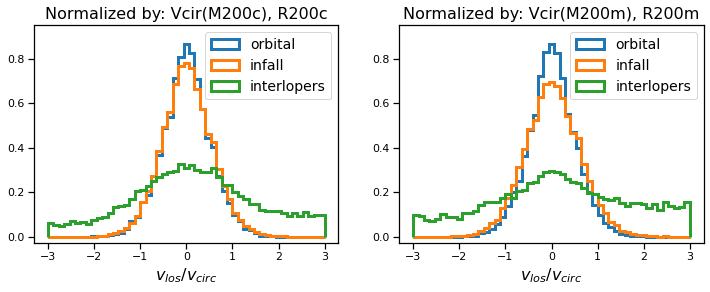

In [335]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

labels = ['orbital','infall','interlopers']
for i in range(3):
    plt.hist(vlosn[cut],bins=51,weights=tag_probability[cut,i],histtype='step', lw=3, label=labels[i],density=True)
# for i in range(3):
#     plt.hist(vlosn2[cut2],bins=51,weights=tag_probability2[cut2,i]
#              ,histtype='step', lw=3, label=labels[i],density=True,
#             color='C%i'%i,ls='--')

plt.legend(fontsize=14)
plt.xlabel(r'$v_{los}/ v_{circ} $',fontsize=16)
plt.title('Normalized by: Vcir(M200c), R200c',fontsize=16)
plt.ylim(-0.025,0.95)

plt.subplot(1, 2, 2)
labels = ['orbital','infall','interlopers']
for i in range(3):
    plt.hist(vlosn2[cut2],bins=51,weights=tag_probability2[cut2,i],histtype='step', lw=3, label=labels[i],density=True)

plt.legend(fontsize=14)
plt.xlabel(r'$v_{los}/ v_{circ} $',fontsize=16)
plt.title('Normalized by: Vcir(M200m), R200m',fontsize=16)
plt.ylim(-0.025,0.95)

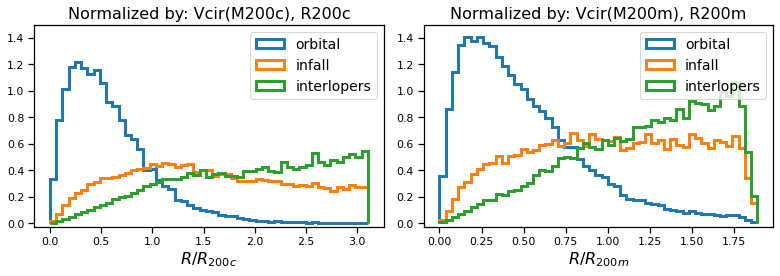

In [342]:
fig = plt.figure(figsize=(11,4))
plt.subplot(1, 2, 1)

labels = ['orbital','infall','interlopers']
for i in range(3):
    plt.hist(rnorm[cut],bins=51,weights=tag_probability[cut,i],histtype='step', lw=3, label=labels[i],density=True)

plt.legend(fontsize=14)
plt.xlabel(r'$R/R_{200c}$',fontsize=16)
plt.title('Normalized by: Vcir(M200c), R200c',fontsize=16)
plt.ylim(-0.025,1.5)

plt.subplot(1, 2, 2)
labels = ['orbital','infall','interlopers']
for i in range(3):
    plt.hist(rnorm2[cut2],bins=51,weights=tag_probability2[cut2,i],histtype='step', lw=3, label=labels[i],density=True)

plt.legend(fontsize=14)
plt.xlabel(r'$R/R_{200m}$',fontsize=16)
plt.title('Normalized by: Vcir(M200m), R200m',fontsize=16)
plt.ylim(-0.025,1.5)
plt.tight_layout()
plt.savefig('../plots/radial_distribtution_prob_weighted.png',dpi=100,facecolor='w',transparent=False)

# Star Forming Galaxies Classification
--------------

In first approach we assume a fixed threshold on ssfr. Next step would be to model with a linear fit.

In [139]:
star_forming = (gal['ssfr']>-11.0)
quenching    = np.logical_not(star_forming)

In [140]:
gal['SF'] = np.array(star_forming).astype(int)

# Match With Morphological Classification
--------------

Here we math the Dominguez et al. 2017 machine learning morphological classification with our sample.

In [141]:
morp_fname = fl.morp_fname

In [142]:
from astropy.io.fits import getdata
from astropy.table import Table

morph = Table(getdata(morp_fname,1))

In [143]:
!cat ../data/README_Morph_catalogue_DS18.txt

#############################################################################
                          
		Morphological catalogue for SDSS galaxies
                     
			current version: v1.0, Feb 2018

#############################################################################

The morphologies have been obtained by applying Deep Learning models to SDSS-DR7 RGB cutouts, as explained in Dominguez Sánchez+18.

The catalogue contains 670,722 rows, one per galaxy.
The meaning of the columns are  (see also Table 3 from DS+18):

Name                 Meaning

 1  - dr7objid     =  SDSS-DR7 ID
 2  - galcount     =  Meert+15 ID
 3  - P_disk       =  Probability of showing disk/features (vs. being smooth)
 4  - P_edge_on    =  Prob. of being edge-on 
 5  - P_bar_GZ2    =  Prob. of having bar signature (trained with GZ2 catalogue)
 6  - P_bar_Nair10 =  Prob. of having bar signature (trained with Nair+10 catalogue)
 7  - P_merg       =  Prob. of being merger/projected pairs
 8  - P_bulge   

In [144]:
morph

_RAJ2000,_DEJ2000,objID,M15,Pdisk,Pedgeon,PbarGZ2,PbarNair10,Pmerg,Pbulge,Pcigar,TType,PS0,Sloan,_RA,_DE
float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,str39,float64,float64
236.2469939,-0.4752639,587722952230174996,1,3.54431e-05,0.646749,0.00570267,0.384967,0.0210895,0.00223408,0.992602,3.40424,0.970816,"gref=""SDSS3.dr12.pos,w ${+_RA}+${+_DE}""",236.24699,-0.47526
236.2870031,-0.5180031,587722952230175035,2,0.000726125,0.00519745,0.000318388,0.36079,0.097683,0.000533296,0.999629,3.32452,0.999759,"gref=""SDSS3.dr12.pos,w ${+_RA}+${+_DE}""",236.287,-0.518
236.341995,-0.4670231,587722952230175138,3,0.966147,0.000429604,0.00116753,0.396651,0.0395277,0.27721,0.143814,2.18678,0.995247,"gref=""SDSS3.dr12.pos,w ${+_RA}+${+_DE}""",236.34199,-0.46702
236.3500061,-0.5982369,587722952230175145,4,0.0765286,1.01519e-05,0.00163528,0.344985,0.0518972,0.0616104,0.000899576,1.80833,0.998581,"gref=""SDSS3.dr12.pos,w ${+_RA}+${+_DE}""",236.35001,-0.59824
236.3690031,-0.57445,587722952230175173,5,0.588999,0.053386,0.000710209,0.462225,0.0431297,0.254238,0.974827,2.63448,0.999394,"gref=""SDSS3.dr12.pos,w ${+_RA}+${+_DE}""",236.369,-0.57445
236.3970031,-0.4934569,587722952230240617,6,0.975294,4.54852e-06,0.0670039,0.344379,0.16815,0.149589,0.00124175,3.08055,0.943991,"gref=""SDSS3.dr12.pos,w ${+_RA}+${+_DE}""",236.397,-0.49346
236.4450069,-0.5062869,587722952230240688,7,0.151808,8.55687e-06,0.0091088,0.591967,0.197335,3.11165e-05,0.275521,5.27911,0.998853,"gref=""SDSS3.dr12.pos,w ${+_RA}+${+_DE}""",236.44501,-0.50629
236.5480039,-0.549335,587722952230306064,8,0.279842,0.988545,0.0406824,0.389922,0.0427533,0.0404572,0.999997,3.47491,0.983288,"gref=""SDSS3.dr12.pos,w ${+_RA}+${+_DE}""",236.548,-0.54933
236.6739961,-0.6193569,587722952230371590,9,5.69442e-06,0.261573,0.000164425,0.105626,0.742849,0.820464,0.474056,0.33168,0.89928,"gref=""SDSS3.dr12.pos,w ${+_RA}+${+_DE}""",236.674,-0.61936


In [145]:
#!pip3 install git+https://github.com/esheldon/smatch/

In [146]:
import smatch

nside=4096 # healpix nside
maxmatch=1 # return closest match

# ra,dec,radius in degrees
matches0 = smatch.match(gal['ra'], gal['dec'], 3.0/3600, morph['_RA'], morph['_DE'], nside=nside, maxmatch=maxmatch)
dist = np.sqrt((gal['ra'][matches0['i1']]-morph['_RA'][matches0['i2']])**2+(gal['dec'][matches0['i1']]-morph['_DE'][matches0['i2']])**2)*3600

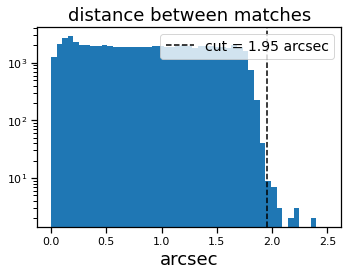

In [147]:
plt.figure(figsize=(5,4))
_ = plt.hist(dist,bins=np.linspace(0.,2.5))
plt.axvline(1.95,ls='--',color='k',label='cut = %.2f arcsec'%(1.95))
plt.yscale('log')
plt.xlabel('arcsec',fontsize=18)
plt.legend(fontsize=14)
plt.title('distance between matches',fontsize=18)
plt.tight_layout()
plt.savefig('../plots/'+'match_distance.png')

In [148]:
matches = smatch.match(gal['ra'], gal['dec'], 2.9/3600, morph['_RA'], morph['_DE'], nside=nside, maxmatch=maxmatch)
dist = np.sqrt((gal['ra'][matches0['i1']]-morph['_RA'][matches0['i2']])**2+(gal['dec'][matches0['i1']]-morph['_DE'][matches0['i2']])**2)*3600

In [149]:
indice1 = matches['i1']
indice2 = matches['i2']
fraction = len(gal[indice1])/len(gal)

print('Fraction matched: %.3f'%fraction)

Fraction matched: 0.981


In [150]:
columns = morph.colnames[4:-3]

print('Selected Columns:',columns)

for col in columns:
    gal[col] = -99.
    gal[col][indice1] = morph[col][indice2]

Selected Columns: ['Pdisk', 'Pedgeon', 'PbarGZ2', 'PbarNair10', 'Pmerg', 'Pbulge', 'Pcigar', 'TType', 'PS0']


# Saving File
---------------------------------------


In [103]:
galaxy_file[:-4]+'_volumeLimited_v1'

'../data/groups_deCarvalho2017_galaxies_final_flag_johnnyheq_volumeLimited_v1'

In [151]:
# fl.gal_fname1 = galaxy_file[:-4]+'_v1.csv'
fl.gal_fname1 = galaxy_file[:-4]+'_volumeLimited_v1'
gal.write(fl.gal_fname1,format='csv',overwrite=True)